## STFT 구현 실습

### 라이브러리 이용

#### librosa 코드

Text(0.5, 1.0, 'Spectrogram (dB)')

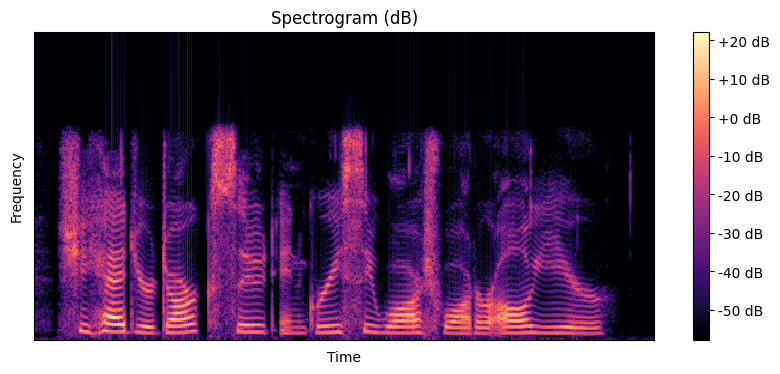

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 파일 불러오기
waveform, sample_rate = librosa.load('Original.wav')

x = waveform
y = librosa.stft(x, n_fft=512, hop_length=128, win_length=512, window='hamming')

magnitude = np.abs(y)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogram, sr=16000, hop_length=128)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#### torchaudio 코드

In [2]:
import numpy as np
import torchaudio
import torch
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt

file_name = 'Original.wav'
x, sr = torchaudio.load(file_name)

c:\Users\chldb\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\chldb\anaconda3\envs\venv\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
c:\Users\chldb\anaconda3\envs\venv\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


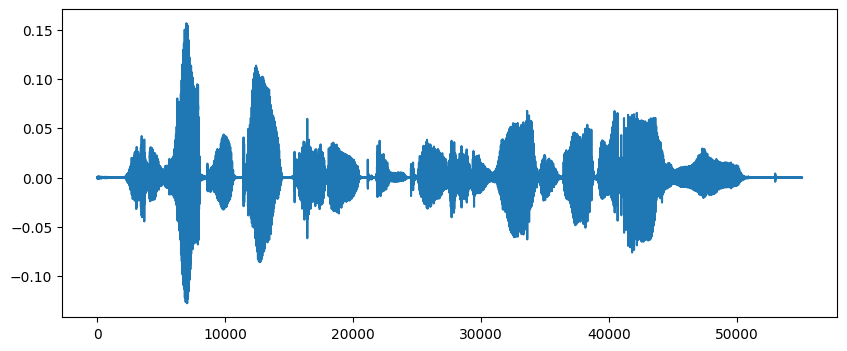

In [3]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x[0, :])
plt.show()

c:\Users\chldb\anaconda3\envs\venv\lib\site-packages\torch\functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
c:\Users\chldb\anaconda3\envs\venv\lib\site-packages\torch\functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
c:\Users\chldb\anaconda3\envs\venv\lib\site-packages\torchaudio\functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may 

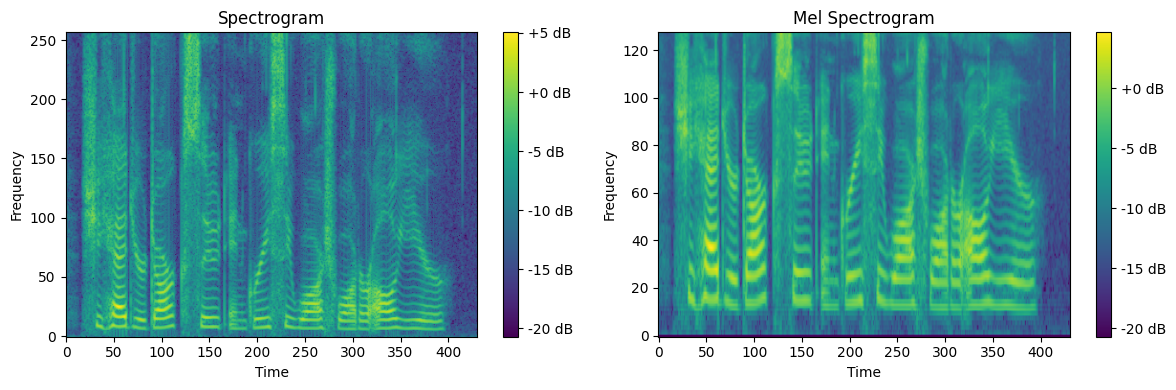

In [4]:
# 입력 신호 로드
waveform, sample_rate = torchaudio.load('Original.wav')

# STFT 파라미터 설정
window_size = 512
hop_size = 128
n_mels = 128

# STFT 변환기 생성
stft_transform = transforms.Spectrogram(n_fft=window_size, hop_length=hop_size, window_fn=torch.hamming_window)

# STFT 계산
stft = stft_transform(waveform)

# Mel 스펙트로그램 변환기 생성
mel_spec_transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=window_size, hop_length=hop_size, n_mels=n_mels)

# Mel 스펙트로그램 계산
mel_spec = mel_spec_transform(waveform)


# 결과 시각화: 일반적인 STFT magnitude
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(torch.log(torch.abs(stft) + 1e-9).squeeze().numpy(), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')

# 결과 시각화: Mel 스케일(인간의 청각 시스템에 더 가까운 형태)로 변환한 STFT magnitude
plt.subplot(1, 2, 2)
plt.imshow(torch.log(mel_spec + 1e-9).squeeze().numpy(), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

### STFT 직접 구현

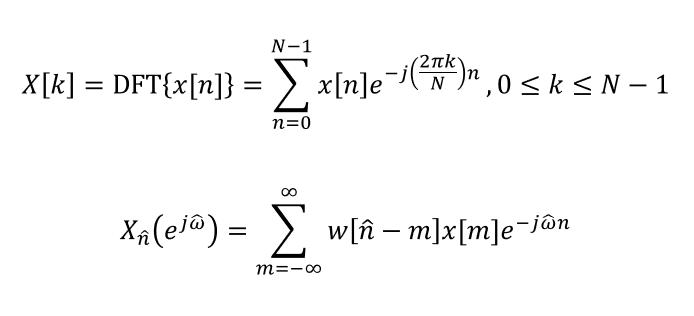

In [13]:
# 신호, 윈도우 길이, 윈도우 shift 정도를 인자로 받음
def stft_func(x, window_length, hop_size):

    # 해밍 윈도우 생성
    window = np.hamming(window_length)  

    # 프레임 개수 계산
    frame_num = 1 + int((len(x) - window_length) /  hop_size)

    # STFT 결과 저장 배열
    stft_spectrogram = np.zeros((frame_num, window_length // 2 + 1), dtype=complex)

    # STFT 수행
    for frame_idx in range(frame_num):
        # 프레임의 시작/끝 인덱스
        start_idx = frame_idx * hop_size
        end_idx = start_idx + window_length
        # 프레임 신호 추출
        framed_signal = window * x[start_idx:end_idx]
        # DFT 계산(frequency bin 개수만큼 반복)
        for freq_idx in range(window_length // 2 + 1):
            # dft 결과 누적 변수
            dft_sum = 0
            # 윈도우 길이만큼 시간 샘플에 대해 DFT 계산
            for time_idx in range(window_length):
                dft_sum += framed_signal[time_idx] * np.exp(-1j * 2 * np.pi * freq_idx * time_idx / window_length)
            stft_spectrogram[frame_idx, freq_idx] = dft_sum

    return stft_spectrogram

In [14]:
# 신호, 윈도우 길이, 윈도우 shift 정도를 인자로 받음
def stft_func(x, window_length, hop_size):

    # 해밍 윈도우 생성
    window = np.hamming(window_length)  

    # 프레임 개수 계산
    frame_num = 1 + int((len(x) - window_length) /  hop_size)

    # STFT 결과 저장 배열
    stft_spectrogram = np.zeros((frame_num, window_length // 2 + 1), dtype=complex)

    # STFT 수행
    for frame_idx in range(frame_num):
        # 프레임의 시작/끝 인덱스
        start_idx = frame_idx * hop_size
        end_idx = start_idx + window_length
        # 프레임 신호 추출
        framed_signal = window * x[start_idx:end_idx]
        # DFT 계산(frequency bin 개수만큼 반복)
        for freq_idx in range(window_length // 2 + 1):
            dft_exp = np.exp(-1j * 2 * np.pi * freq_idx * np.arange(window_length) / window_length)
            dft_sum = (framed_signal * dft_exp).sum()
            stft_spectrogram[frame_idx, freq_idx] = dft_sum

    return stft_spectrogram

In [5]:
# 신호, 윈도우 길이, 윈도우 shift 정도를 인자로 받음
def stft_func(x, window_length, hop_size):

    # 해밍 윈도우 생성
    window = np.hamming(window_length)  

    # 프레임 개수 계산
    frame_num = 1 + int((len(x) - window_length) /  hop_size)

    # STFT 결과 저장 배열
    stft_spectrogram = np.zeros((frame_num, window_length // 2 + 1), dtype=complex)

    # STFT 수행
    for frame_idx in range(frame_num):
        # 프레임의 시작/끝 인덱스
        start_idx = frame_idx * hop_size
        end_idx = start_idx + window_length
        # 프레임 신호 추출
        framed_signal = window * x[start_idx:end_idx]
        # DFT 계산 (frequency bins / time frames)
        time_idx = np.expand_dims(np.arange(window_length), 0)
        freq_idx = np.expand_dims(np.arange(window_length // 2 + 1), 1)
        dft_exp = np.exp(-1j * 2 * np.pi * freq_idx * time_idx / window_length)
        stft_spectrogram[frame_idx] = (np.expand_dims(framed_signal, 0) * dft_exp).sum(1)

    return stft_spectrogram

Text(0.5, 1.0, 'Implemented Spectrogram')

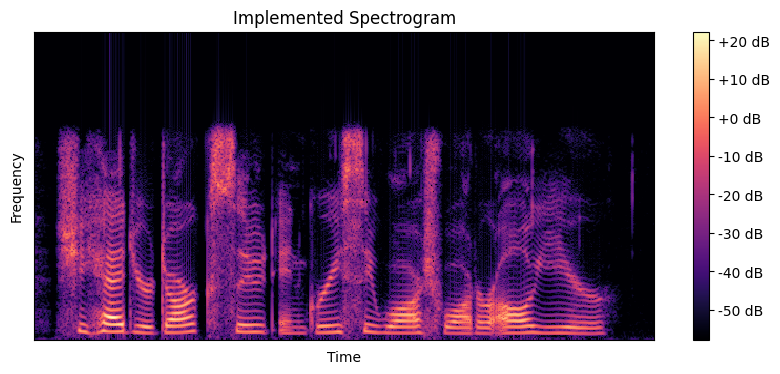

In [8]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

waveform, sample_rate = librosa.load('Original.wav')

x = librosa.load('Original.wav')[0]
y = stft_func(x, 512, 128)

magnitude = np.abs(y)
log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogram.T, sr=16000, hop_length=128)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Implemented Spectrogram")

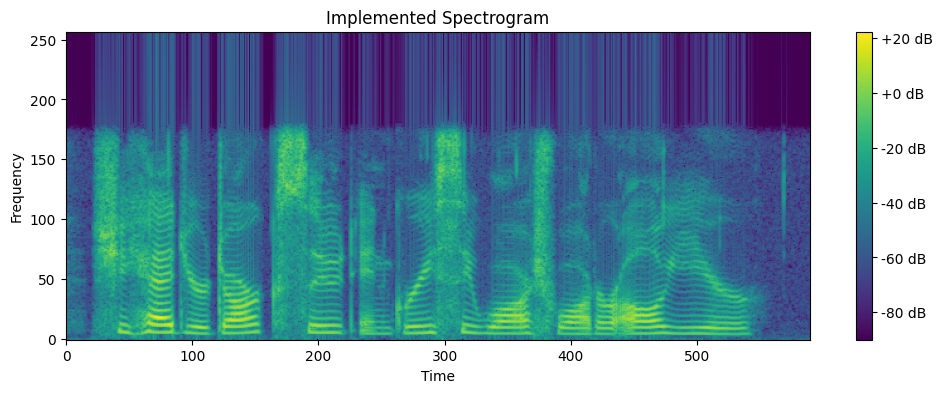

In [7]:
# 입력 신호 로드
waveform, sample_rate = torchaudio.load('Original.wav')

# STFT 파라미터 설정
window_size = 512
hop_size = 128
n_mels = 128


# STFT 계산
stft = (torch.tensor(stft_func(x, window_size, hop_size)).T).unsqueeze(0)

# 결과 시각화: 일반적인 STFT magnitude
plt.figure(figsize=(12, 4))
plt.imshow(10*torch.log10((torch.abs(stft))**2 + 1e-9).squeeze().numpy(), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Implemented Spectrogram')
plt.colorbar(format='%+2.0f dB')